<a href="https://colab.research.google.com/github/LakhiCharanMahato/Weather-Analysis-across-various-states-of-North-America/blob/master/New%20York/NY_note3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Requirements

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install ipyleaflet

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()

# Library Requirements

**On the left hand side the storage icon is the local storage for Google colab. Make a folder name lib there and upload all the items from Weather-Analysis-across-various-states-of-North-America/New York/lib/**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Spectral Analysis of Snow Depth in NY state




  * *TMIN* Minimal Temperature during the day.
  * *TMAX* Maximal Temperature During the day.
  * *TOBS* "Observed" temperature. Exact meaning not clear, but is less noisy than *TMIN* and *TMAX*
  * *PRCP* Total percipitation during the day.
  * *SNOW* Amount of snow that fell during the day.
  * *SNWD* Snow Depth
  * *TMIN_s20*, *TMAX_s20*,... A smoothed version of the six raw measurements.

In [0]:
#setup
data_dir='../Data/Weather'
#!ls $data_dir
state='NY'
m='SNWD'

In [0]:
import ipyleaflet
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [0]:
import os
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *



from lib.import_modules import import_modules,modules
import_modules(modules)

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.25.3 	required version>=0.19.2

     numpy as    np 	version=1.18.2 	required version>=1.12.0



/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Circle', 'Rectangle', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


   sklearn as    sk 	version=0.22.2.post1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.5 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.5.1 	required version>=6.0.0

version of ipwidgets= 7.5.1


In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [0]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


In [0]:
#read statistics
%mkdir -p $data_dir
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  16.9M      0  0:00:01  0:00:01 --:--:-- 16.9M
../Data/Weather/STAT_NY.pickle.gz
-rw-r--r-- 1 root root 31373293 Mar 29 17:23 ../Data/Weather/STAT_NY.pickle.gz


In [0]:
from pickle import load
#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [0]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

In [0]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  23.2M      0  0:00:02  0:00:02 --:--:-- 23.2M
-rw-r--r-- 1 root root 64M Mar 29 17:24 ../Data/Weather/NY.tgz
/Data/Weather
77828	./NY.parquet
/content


In [0]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+------------------+--------+------------------+-----------------+--------+
|    Station|Measurement|Year|              Values|        dist_coast|latitude|         longitude|        elevation|    name|
+-----------+-----------+----+--------------------+------------------+--------+------------------+-----------------+--------+
|USC00308600|       SNWD|1932|[00 7E 00 7E 00 7...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1956|[00 7E 00 7E 00 7...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1957|[C0 54 C0 54 C0 5...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1958|[00 00 00 00 00 0...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TROY L&D|
|USC00308600|       SNWD|1959|[00 00 40 4E 40 4...|171.58099365234375|   42.75|-73.68329620361328|7.300000190734863|TR

In [0]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

CPU times: user 22.6 ms, sys: 3.54 ms, total: 26.1 ms
Wall time: 1.18 s


In [0]:
%%time
print(df2.count())

14617
CPU times: user 2.73 ms, sys: 355 µs, total: 3.08 ms
Wall time: 8.03 s


In [0]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   435k      0 --:--:-- --:--:-- --:--:--  436k
/Data/Weather
13104	decon_NY_PRCP_s20.parquet
1924	decon_NY_SNWD.parquet
77828	NY.parquet
1924	recon_NY_SNWD.parquet
420	stations.parquet
/content


In [0]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet').drop('Dist_coast').drop('Elevation').drop('Latitude').drop('Longitude').drop('Name')

In [0]:
jdf=df2.join(stations_df,on='Station',how='left')
jdf.show(1)

+-----------+-----------+--------------------+----+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+--------+------------------+--------+------------------+------------------+------------------+------------------+------------------+--------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|           coeff_2|           coeff_3|          coeff_4|            coeff_5|        dist_coast|        elevation|latitude|         longitude|    name|             res_1|             res_2|             res_3|             res_4|             res_5|res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+------------------+------------------+-----------------+-------------------+------------------+-----------------+--------+------------------+--------+------------------+------------------+------------------+------------------+------------------+---

In [0]:
%%time
#filter out vectors for which the mean is a worse approximation than zero.
print('all Rows',jdf.count())
df3=jdf.filter(jdf.res_mean<1)
print('Rows where mean is better approx than zero',df3.count())

all Rows 14617
Rows where mean is better approx than zero 8174
CPU times: user 5.17 ms, sys: 1.23 ms, total: 6.4 ms
Wall time: 1.11 s


In [0]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

!du -sh $data_dir/*.parquet

13M	../Data/Weather/decon_NY_PRCP_s20.parquet
1.9M	../Data/Weather/decon_NY_SNWD.parquet
77M	../Data/Weather/NY.parquet
1.9M	../Data/Weather/recon_NY_SNWD.parquet
420K	../Data/Weather/stations.parquet


In [0]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: cannot create directory ‘r_figures’: File exists


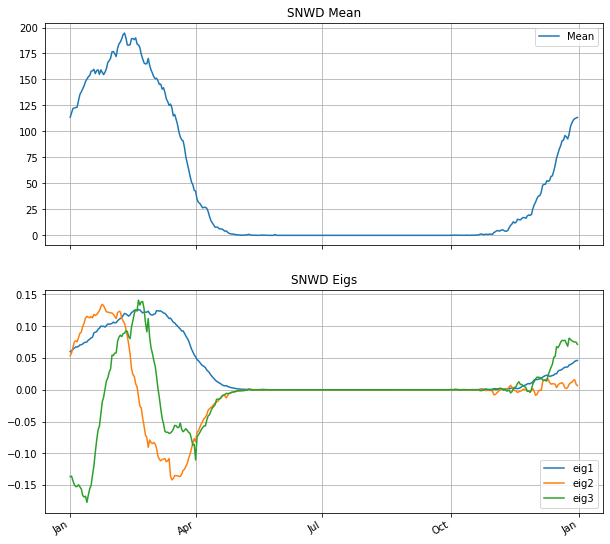

In [0]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('r_figures/SNWD_mean_eigs')

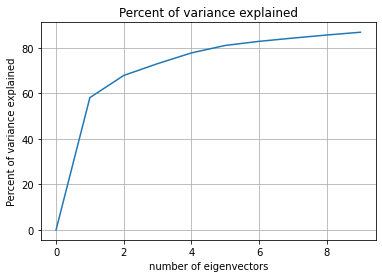

In [0]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Exploring the Decomposition

In [0]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

(365, 3)


(365, 4)

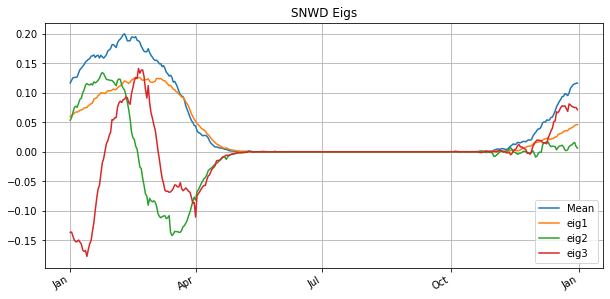

In [0]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 2

In [0]:
df4=df3.filter(df3.res_2<0.1).sort(df3.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

216


In [0]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|5834.375859...|-4358.86473...|-1413.70280...|0.415781391...|0.093341629...|0.064083341...|
|6101.635000...|-4194.93175...|241.5286385...|0.358770222...|0.094581908...|0.094307960...|
|11409.24299...|-3501.89021...|435.9796661...|0.134821347...|0.053313919...|0.052050567...|
|10996.87201...|-3174.50910...|2029.367114...|0.156513816...|0.086223939...|0.057498884...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



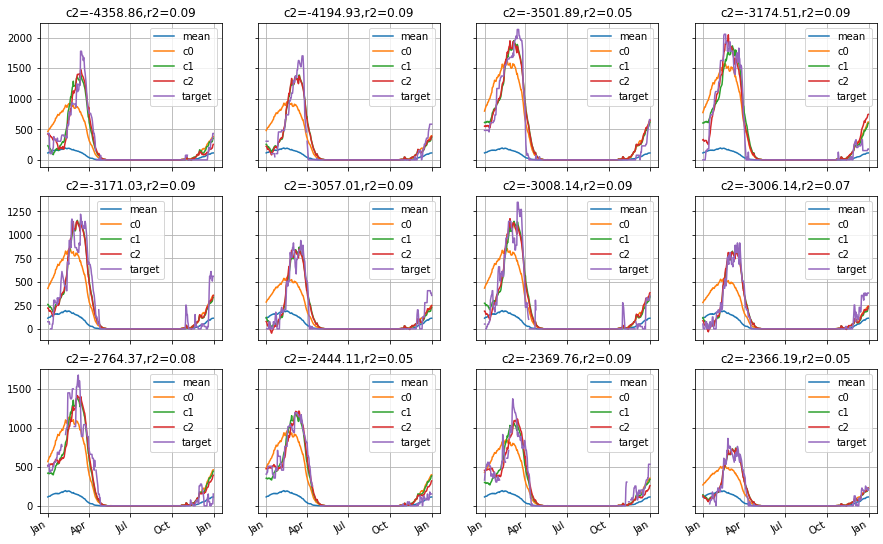

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

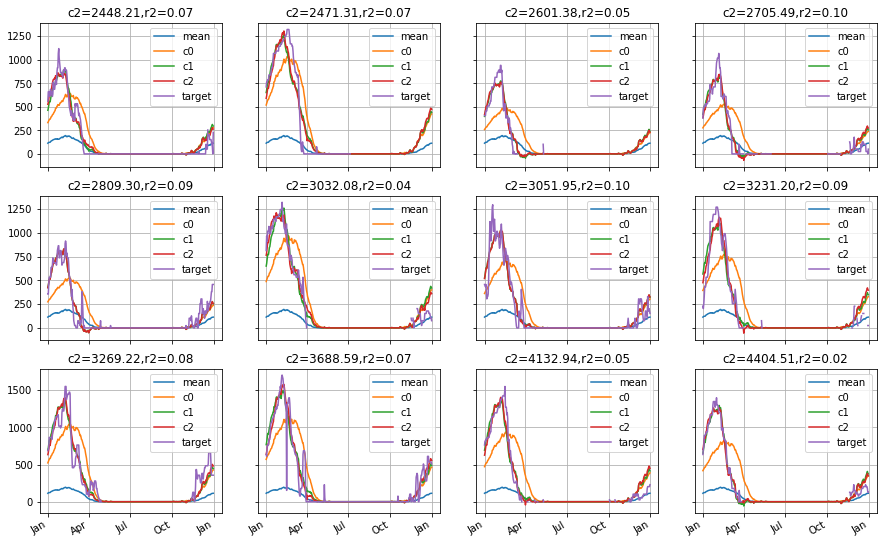

In [0]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 3

In [0]:
df4=df3.filter(df3.res_3<0.1).sort(df3.coeff_3)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

324


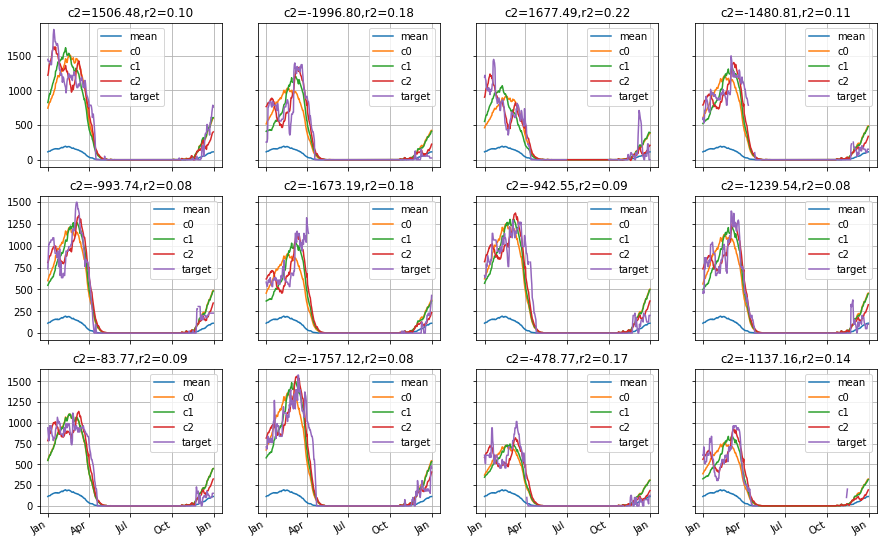

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

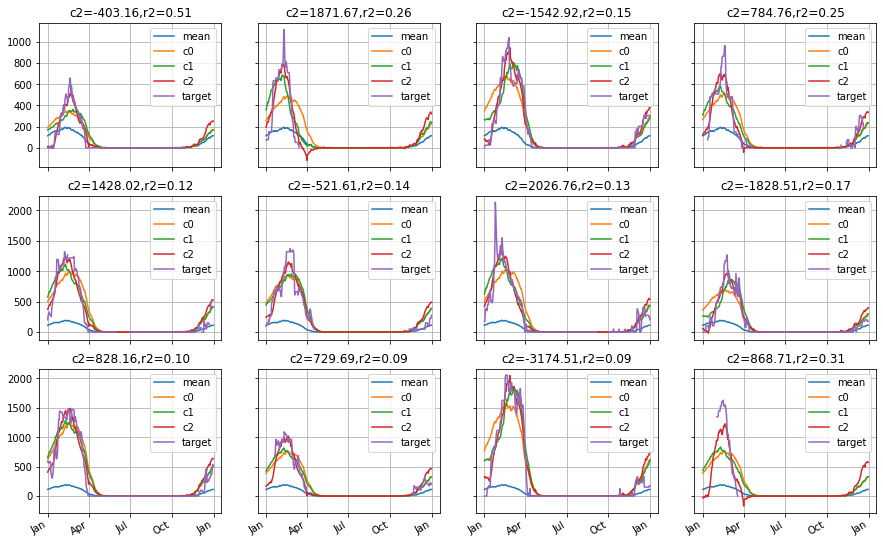

In [0]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)

In [0]:
df4=df3.sort(df3.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

8174
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|6671.358980...|-1651.46745...|-561.841928...|0.020110417...|
|5052.236768...|4404.510874...|-362.489777...|0.020525853...|
|5924.750266...|-1034.99396...|-119.732078...|0.022097266...|
|8393.054466...|-1384.16864...|-423.096239...|0.022246089...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



## Best Fit

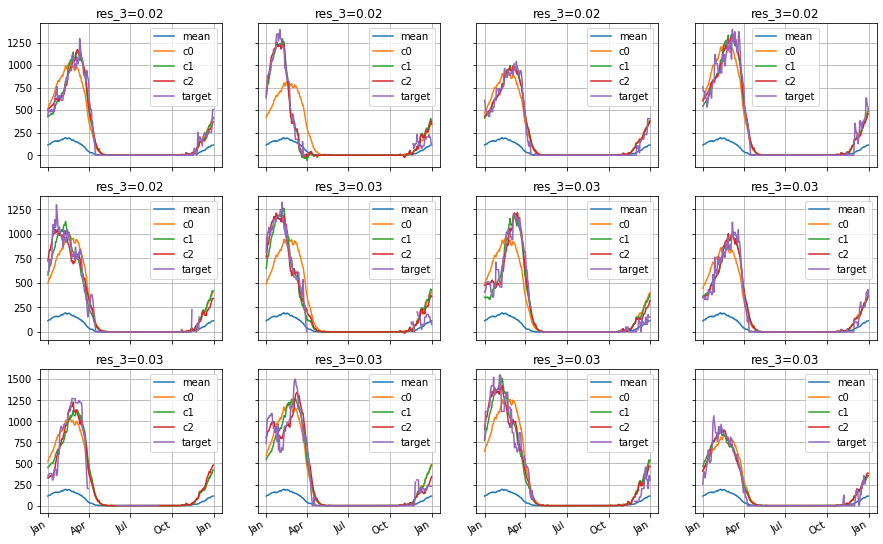

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Worst Fit

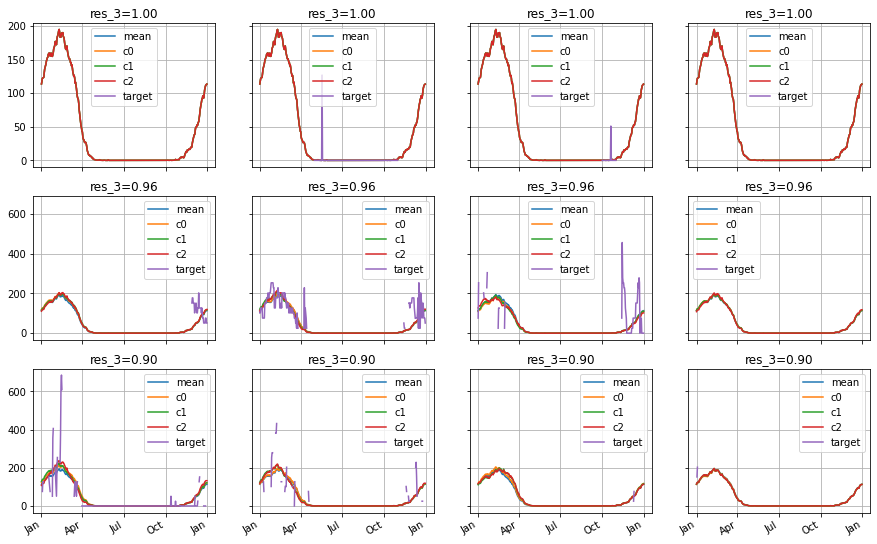

In [0]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Interactive plot of reconstruction

In [0]:
row=all_rows[-6]
target=np.array(unpackArray(row.Values,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.9981279102858719
residual normalized norm  after mean + top eigs: [0.99999991 0.99999945 0.99999945]


In [0]:
pdf=df3.select(['Station','Year','coeff_1','coeff_2','coeff_3','res_1','res_2','res_3','res_mean','total_var']).toPandas()

In [0]:
pdf.columns

Index(['Station', 'Year', 'coeff_1', 'coeff_2', 'coeff_3', 'res_1', 'res_2',
       'res_3', 'res_mean', 'total_var'],
      dtype='object')

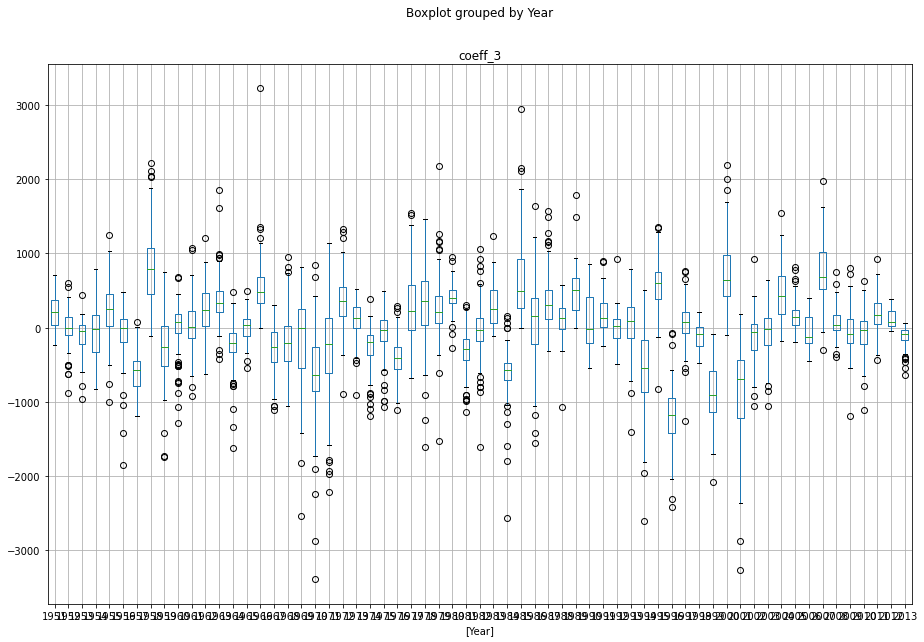

In [0]:
pdf[['Year','coeff_3']][pdf['Year']>1950].boxplot(by='Year',figsize=[15,10])

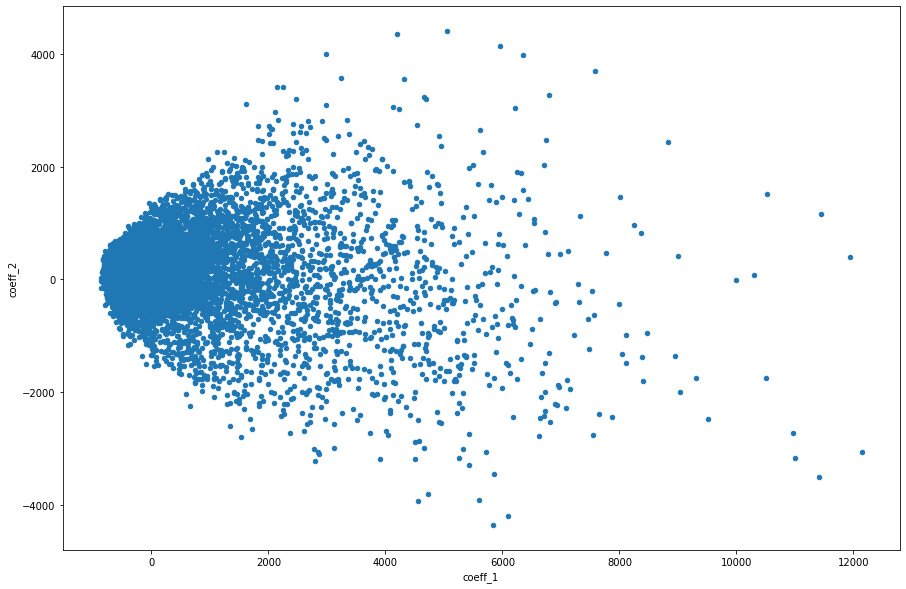

In [0]:
pdf.plot.scatter('coeff_1','coeff_2',figsize=[15,10])

In [0]:
grpby=pdf.groupby('Year')['coeff_1']
ratio=grpby.mean()/grpby.std()
np.nanmax(ratio),np.nanmin(ratio)

(1.0582367314744345, -0.9333313252469626)

In [0]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df4.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    axis.plot(vals,P,label=feat)

In [0]:
df4.columns

['Station',
 'Measurement',
 'Values',
 'Year',
 'coeff_1',
 'coeff_2',
 'coeff_3',
 'coeff_4',
 'coeff_5',
 'dist_coast',
 'elevation',
 'latitude',
 'longitude',
 'name',
 'res_1',
 'res_2',
 'res_3',
 'res_4',
 'res_5',
 'res_mean',
 'total_var',
 'State']

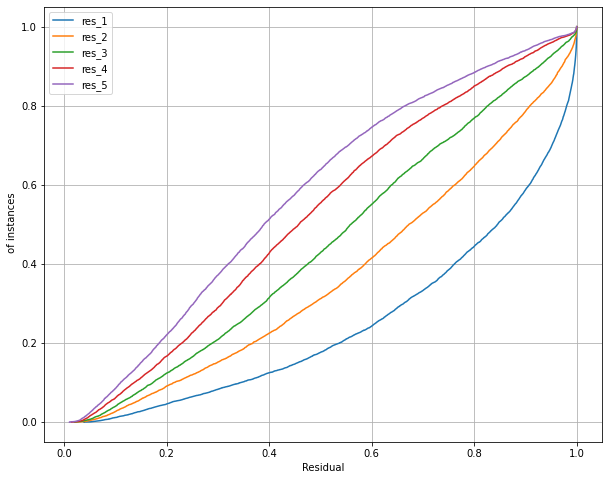

In [0]:
figure(figsize=(10,8))
axis=gca()

#plot_CDF('res_mean') # why does this not fit?
plot_CDF('res_1')
plot_CDF('res_2')
plot_CDF('res_3')
plot_CDF('res_4')
plot_CDF('res_5')
ylabel(' of instances')
xlabel('Residual')
grid()
legend()

In [0]:
filename=data_dir+'/recon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

## Visualizing the distribution coefficients on a map

In [0]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

In [0]:
data_dir='../Data/Weather/'
!du -sh $data_dir/*

13M	../Data/Weather//decon_NY_PRCP_s20.parquet
1.9M	../Data/Weather//decon_NY_SNWD.parquet
77M	../Data/Weather//NY.parquet
64M	../Data/Weather//NY.tgz
1.9M	../Data/Weather//recon_NY_SNWD.parquet
420K	../Data/Weather//stations.parquet
49M	../Data/Weather//STAT_NY.pickle
348K	../Data/Weather//Weather_Stations.tgz


In [0]:
stations_df=sqlContext.read.parquet(data_dir+'/stations.parquet')
stations_df.show(3)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 3 rows



In [0]:
### Read the data frame from a parquet file.

state='NY'
meas='SNWD'

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

8174
+-----------+-----------+--------------------+----+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+------------------+-----------------+------------------+-------------------+------------------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|           coeff_2|           coeff_3|           coeff_4|           coeff_5|        dist_coast|       elevation|          latitude|         longitude|     name|             res_1|             res_2|            res_3|             res_4|              res_5|          res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+------------------+-----

In [0]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,Dist_coast,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)

df2=df1.groupby(['station','latitude','longitude','elevation','Dist_coast']).agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

SELECT station, latitude,longitude,elevation,Dist_coast,coeff_1 FROM weather


,station,latitude,longitude,elevation,Dist_coast,count(station),avg(coeff_1)
294,USC00300015,43.900002,-76.066704,121.900002,376.802002,25,1550.908341
182,USC00300023,42.101398,-77.234398,304.500000,296.167999,46,-90.305486
275,USC00300047,42.646099,-73.747200,0.000000,166.001007,4,-107.478530
69,USC00300055,43.272202,-78.166397,134.100006,436.303009,29,43.864554
239,USC00300063,42.469700,-73.926697,185.000000,152.889999,5,-6.938177


In [0]:
# Find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()


In [0]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))


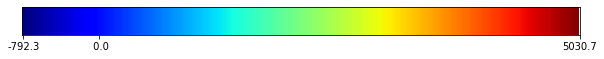

In [0]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
figure(figsize=[10,1])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());


In [0]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

TypeError: ignored

(-100.0, 1000.0)

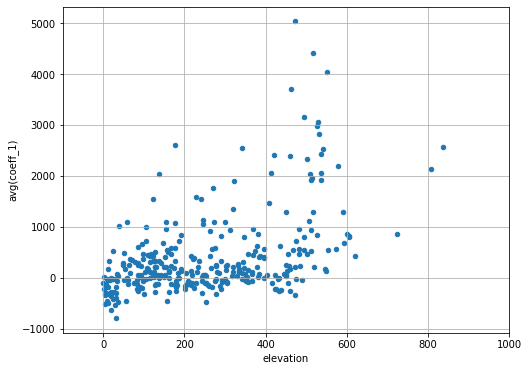

In [0]:
pdf.plot.scatter(x='elevation',y='avg(coeff_1)',figsize=(8,6));
grid()
xlim([-100,1000])

# Spectral Analysis of smoothed PRCP in NY state

In [0]:
#setup
data_dir='../Data/Weather'
#!ls $data_dir
state='NY'
m='PRCP_s20'
from lib.getFiles import *

In [0]:
get_weather_files(state,data_dir)
!du -h $data_dir

1.9M	../Data/Weather/recon_NY_SNWD.parquet
1.9M	../Data/Weather/decon_NY_SNWD.parquet
77M	../Data/Weather/NY.parquet
420K	../Data/Weather/stations.parquet
13M	../Data/Weather/decon_NY_PRCP_s20.parquet
206M	../Data/Weather


In [0]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [0]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

In [0]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

In [0]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

In [0]:
%%time
print(df2.count())

In [0]:
df2.show(1)

In [0]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
filename

In [0]:
df2.write.parquet(filename)

In [0]:
!du -sh $data_dir/*.parquet

In [0]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [0]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title(m+' Percent of variance explained');

## Exploring the decomposition

In [0]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

In [0]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 1

In [0]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_1)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

In [0]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

In [0]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 2

In [0]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

In [0]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))

## Best Fit

In [0]:
df4=df2.sort(df2.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

In [0]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Worst fit

In [0]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## Interactive plot of reconstruction

In [0]:
row=rows[5]
target=np.array(unpackArray(row.Values,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())